In [1]:
import os

import numpy as np
from PIL import Image

In [3]:
train_dir = 'imgs/train'
test_dir = 'imgs/test'
csv_file = 'driver_imgs_list.csv'

In [14]:
def load_grayscale_images_from_folder_as_dict(base_folder, size=(112, 112)):
    images_by_label = {}

    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)
        
        if os.path.isdir(folder_path):
            label = folder[-1]
            images_by_label[label] = []

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                
                try:
                    img = Image.open(img_path).convert('L').resize(size)
                    images_by_label[label].append(np.array(img))
                except IOError:
                    print(f"Error in reading {img_path}. Skipping.")

    return images_by_label

In [15]:
labels_to_images = load_grayscale_images_from_folder_as_dict(train_dir)

In [17]:
labels_to_images.keys()

dict_keys(['7', '2', '1', '3', '0', '4', '5', '6', '9', '8'])

In [18]:
def calculate_average_images(labels_to_images):
    labels_to_averaged_images = {}
    
    for label, images in labels_to_images.items():
        stack_of_images = np.stack(images, axis=0)
        average_image = np.mean(stack_of_images, axis=0).astype(np.uint8)
        labels_to_averaged_images[label] = average_image
        
    return labels_to_averaged_images

In [19]:
labels_to_averaged_images = calculate_average_images(labels_to_images)

In [21]:
len(labels_to_averaged_images)

10

In [22]:
import matplotlib.pyplot as plt

In [29]:
class_to_label = {
    '0': "safe driving",
    '1': "texting - right",
    '2': "talking on the phone - right",
    '3': "texting - left",
    '4': "talking on the phone - left",
    '5': "operating the radio",
    '6': "drinking",
    '7': "reaching behind",
    '8': "hair and makeup",
    '9': "talking to passenger",
}

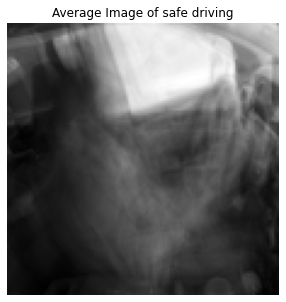

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(labels_to_averaged_images['0'], cmap='gray')
plt.title(f'Average Image of {class_to_label["0"]}')
plt.axis('off')
plt.show()

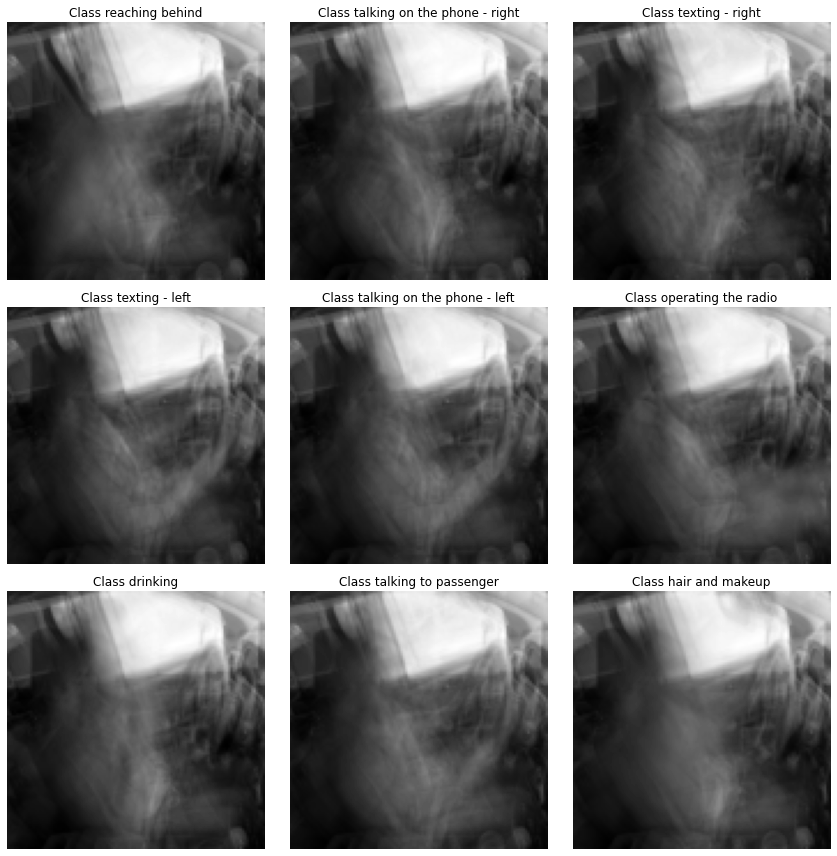

In [33]:
n_classes = len(labels_to_averaged_images) - ('0' in labels_to_averaged_images)
cols = 3
rows = (n_classes + cols - 1) // cols

plt.figure(figsize=(cols * 4, rows * 4))


subplot_index = 1

for label, average_image in labels_to_averaged_images.items():
    if label == '0':
        continue
    plt.subplot(rows, cols, subplot_index)
    plt.imshow(average_image, cmap='gray')
    plt.title(f'Class {class_to_label[label]}')
    plt.axis('off')
    subplot_index += 1

plt.tight_layout()
plt.show()

In [34]:
def plot_difference_from_safe_driving(labels_to_averaged_images, class_to_label):
    safe_driving_image = labels_to_averaged_images['0']

    n_classes = len(labels_to_averaged_images) - 1
    cols = 3
    rows = (n_classes + cols - 1) // cols

    plt.figure(figsize=(cols * 5, rows * 5))

    index = 1
    for label, average_image in labels_to_averaged_images.items():
        if label == '0':
            continue

        difference_image = np.abs(average_image.astype(np.int16) - safe_driving_image.astype(np.int16))
        
        normalized_difference_image = (255 * (difference_image / np.max(difference_image))).astype(np.uint8)

        plt.subplot(rows, cols, index)
        plt.imshow(normalized_difference_image, cmap='bwr', vmin=0, vmax=255)
        plt.title(f"Difference from '{class_to_label[label]}'")
        plt.axis('off')
        index += 1

    plt.tight_layout()
    plt.show()

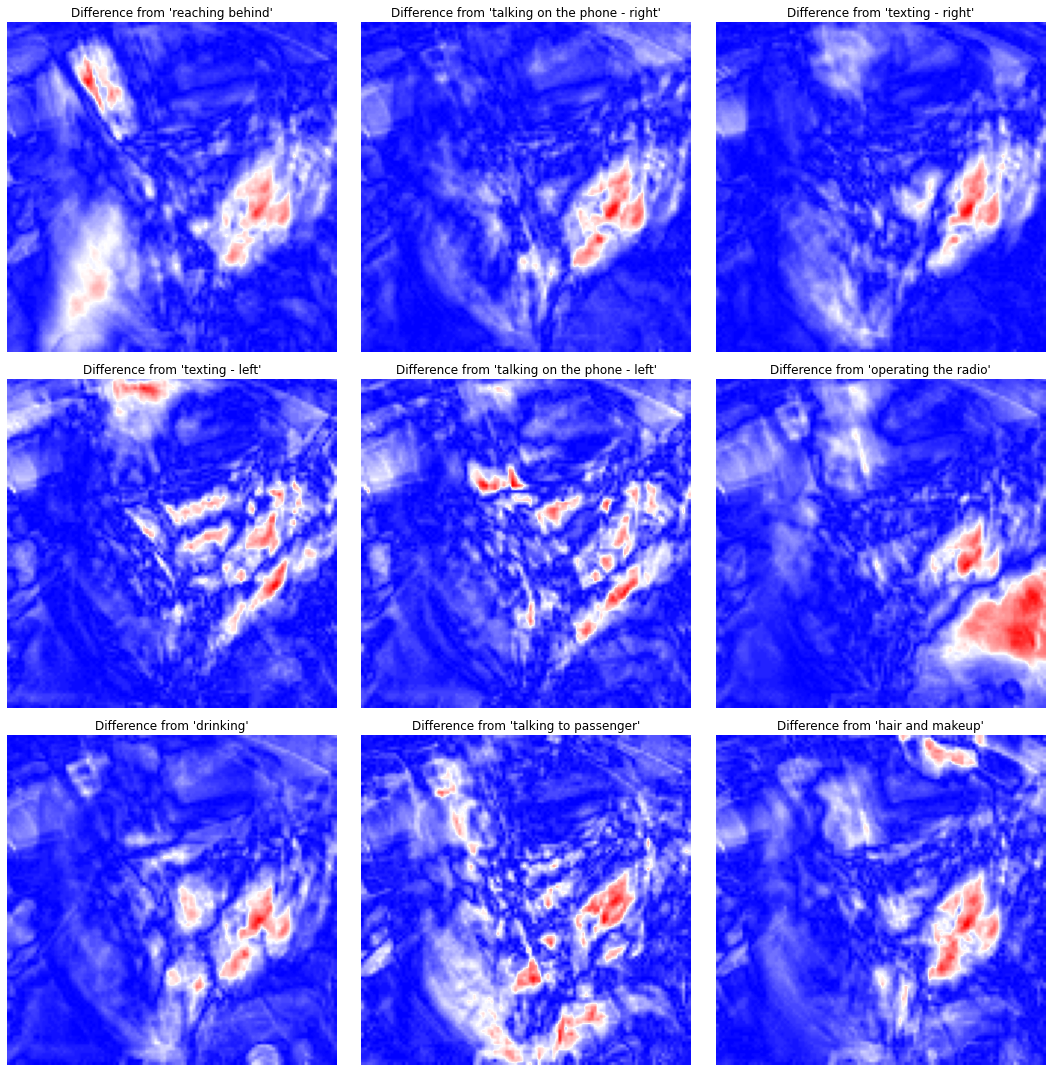

In [35]:
plot_difference_from_safe_driving(labels_to_averaged_images, class_to_label)

In [37]:
def plot_left_right_behavior_differences(labels_to_averaged_images, class_to_label):
    texting_right = labels_to_averaged_images['1']
    texting_left = labels_to_averaged_images['3']
    talking_right = labels_to_averaged_images['2']
    talking_left = labels_to_averaged_images['4']
    
    difference_texting = np.abs(texting_right.astype(np.int16) - texting_left.astype(np.int16))
    difference_talking = np.abs(talking_right.astype(np.int16) - talking_left.astype(np.int16))
    
    normalized_difference_texting = (255 * (difference_texting / np.max(difference_texting))).astype(np.uint8)
    normalized_difference_talking = (255 * (difference_talking / np.max(difference_talking))).astype(np.uint8)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(normalized_difference_texting, cmap='bwr', vmin=0, vmax=255)
    axes[0].set_title('Difference in Texting Behavior')
    axes[0].axis('off')  # Hide the axis
    
    axes[1].imshow(normalized_difference_talking, cmap='bwr', vmin=0, vmax=255)
    axes[1].set_title('Difference in Talking Behavior')
    axes[1].axis('off')  # Hide the axis
    
    plt.tight_layout()
    plt.show()

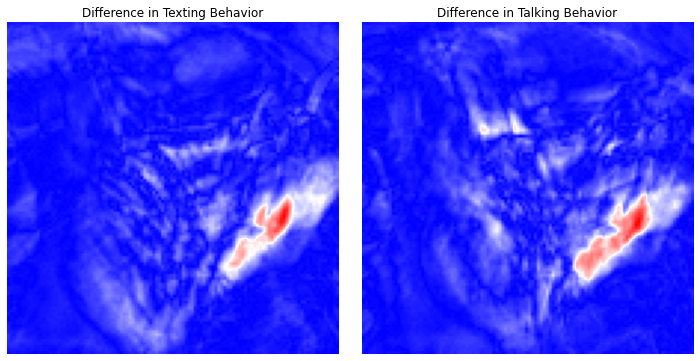

In [38]:
plot_left_right_behavior_differences(labels_to_averaged_images, class_to_label)

In [39]:
def plot_grouped_comparisons(labels_to_averaged_images, class_to_label):
    # Define the groups
    hands_activities_labels = ['1', '2', '3', '4']  # texting and talking on the phone
    hands_free_activities_labels = ['5', '9']       # operating the radio and talking to passenger
    
    looking_away_labels = ['1', '3', '7', '8']     # texting, reaching behind, hair and makeup
    not_looking_away_labels = ['2', '4', '6', '9'] # talking on the phone, drinking, talking to passenger
    
    hands_activities_avg = np.mean([labels_to_averaged_images[label] for label in hands_activities_labels], axis=0)
    hands_free_activities_avg = np.mean([labels_to_averaged_images[label] for label in hands_free_activities_labels], axis=0)
    
    looking_away_avg = np.mean([labels_to_averaged_images[label] for label in looking_away_labels], axis=0)
    not_looking_away_avg = np.mean([labels_to_averaged_images[label] for label in not_looking_away_labels], axis=0)
    
    hands_activities_avg = (hands_activities_avg / np.max(hands_activities_avg) * 255).astype(np.uint8)
    hands_free_activities_avg = (hands_free_activities_avg / np.max(hands_free_activities_avg) * 255).astype(np.uint8)
    
    looking_away_avg = (looking_away_avg / np.max(looking_away_avg) * 255).astype(np.uint8)
    not_looking_away_avg = (not_looking_away_avg / np.max(not_looking_away_avg) * 255).astype(np.uint8)
    
    hands_vs_hands_free_diff = np.abs(hands_activities_avg.astype(np.int16) - hands_free_activities_avg.astype(np.int16))
    looking_away_vs_not_diff = np.abs(looking_away_avg.astype(np.int16) - not_looking_away_avg.astype(np.int16))
    
    hands_vs_hands_free_diff = (255 * (hands_vs_hands_free_diff / np.max(hands_vs_hands_free_diff))).astype(np.uint8)
    looking_away_vs_not_diff = (255 * (looking_away_vs_not_diff / np.max(looking_away_vs_not_diff))).astype(np.uint8)
    
    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(hands_vs_hands_free_diff, cmap='bwr', vmin=0, vmax=255)
    axes[0].set_title('Hands vs Hands-Free Activities')
    axes[0].axis('off')
    
    axes[1].imshow(looking_away_vs_not_diff, cmap='bwr', vmin=0, vmax=255)
    axes[1].set_title('Looking Away vs Not Looking Away Activities')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

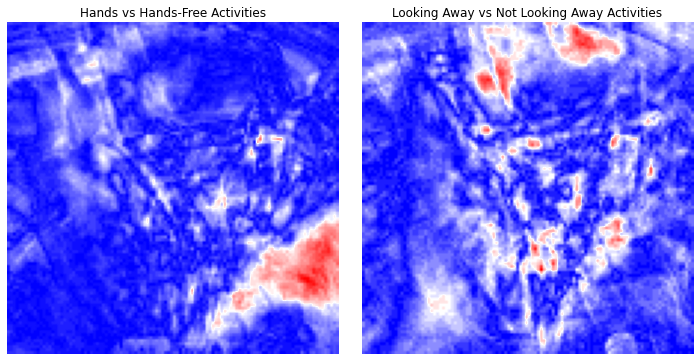

In [40]:
plot_grouped_comparisons(labels_to_averaged_images, class_to_label)

In [43]:
def plot_aggregated_activity_heatmaps(labels_to_averaged_images, class_to_label):
    activity_labels = [label for label in labels_to_averaged_images if label != '0']
    
    aggregated_activities = np.mean([labels_to_averaged_images[label] for label in activity_labels], axis=0)
    
    safe_driving_image = labels_to_averaged_images['0']
    
    aggregated_activities_normalized = (aggregated_activities / np.max(aggregated_activities) * 255).astype(np.uint8)
    
    difference_image = np.abs(aggregated_activities_normalized.astype(np.int16) - safe_driving_image.astype(np.int16))
    
    normalized_difference_image = (255 * (difference_image / np.max(difference_image))).astype(np.uint8)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(aggregated_activities_normalized, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Aggregated Activities Heatmap')
    axes[0].axis('off')  # Hide the axis
    
    axes[1].imshow(normalized_difference_image, cmap='bwr', vmin=0, vmax=255)
    axes[1].set_title('Difference from Safe Driving')
    axes[1].axis('off')  # Hide the axis
    
    plt.tight_layout()
    plt.show()

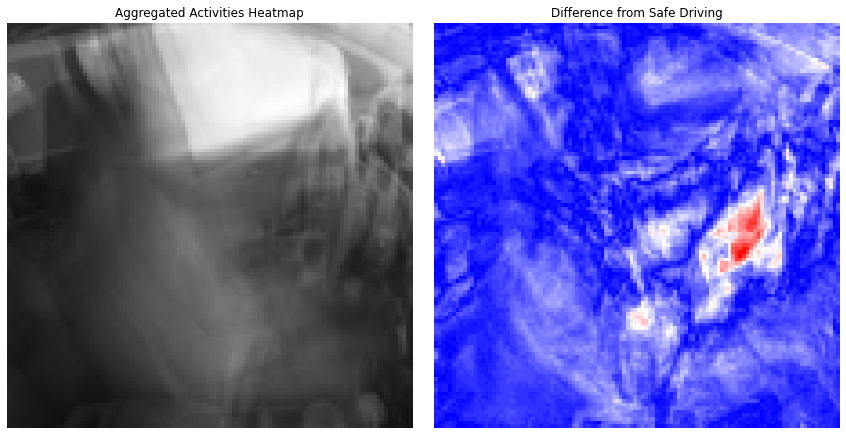

In [44]:
plot_aggregated_activity_heatmaps(labels_to_averaged_images, class_to_label)